In [54]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
# datasnaek_chess_path = kagglehub.dataset_download('datasnaek/chess')

print('Data source import complete.')


Data source import complete.


In [55]:
import kagglehub
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
# Download latest version

data_path = "/kaggle/input/chess/games.csv"
print(data_path)

/kaggle/input/chess/games.csv


In [56]:
df = pd.read_csv(data_path)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


Pakai kalau kamu punya label (target) yang jelas dan ingin memprediksi sesuatu.

Contoh target yang bisa dipakai dari dataset ini:

Memprediksi siapa yang menang (Winner)
→ fitur: rating putih/hitam, opening, jumlah langkah, dll
→ model: klasifikasi (White, Black, Draw)

Memprediksi apakah game rated atau tidak (Rated)
→ fitur: rating, status, opening, durasi
→ model: klasifikasi (binary)

Memprediksi jumlah langkah (Number of Turns)
→ model: regresi

📌 Model yang cocok:

Random Forest, XGBoost, Logistic Regression, SVM, dll.

In [58]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


<Axes: >

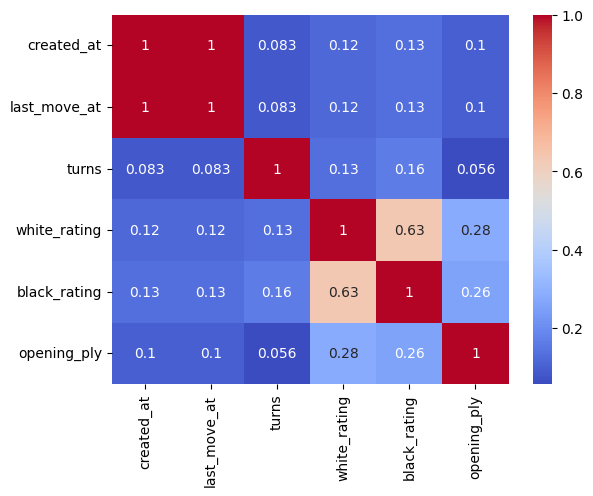

In [59]:
corr_matrix = df.select_dtypes(include=np.number).corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

In [60]:
df.duplicated().sum()

np.int64(429)

In [61]:
df.select_dtypes(include=np.number).describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


In [62]:
df.select_dtypes(include='object').describe()

,id,victory_status,winner,increment_code,white_id,black_id,moves,opening_eco,opening_name
count,20058,20058,20058,20058,20058,20058,20058,20058,20058
unique,19113,4,3,400,9438,9331,18920,365,1477
top,XRuQPSzH,resign,white,10+0,taranga,taranga,e4 e5,A00,Van't Kruijs Opening
freq,5,11147,10001,7721,72,82,27,1007,368


In [63]:
df.isnull().sum()

,0
id,0
rated,0
created_at,0
last_move_at,0
turns,0
victory_status,0
winner,0
increment_code,0
white_id,0
white_rating,0


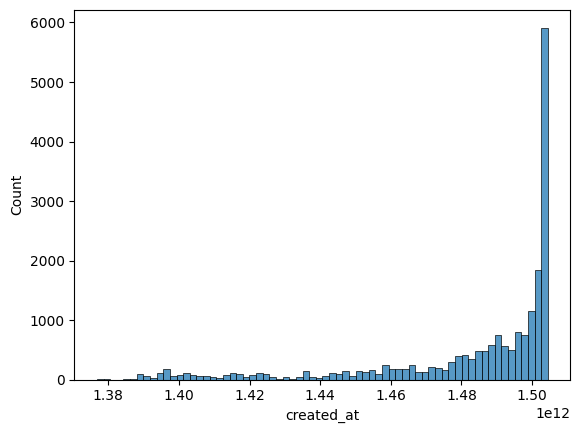

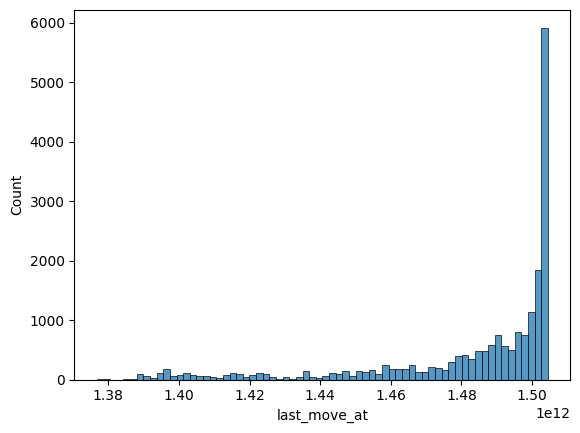

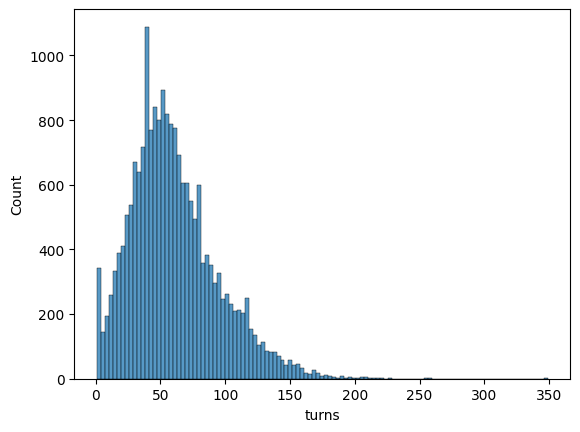

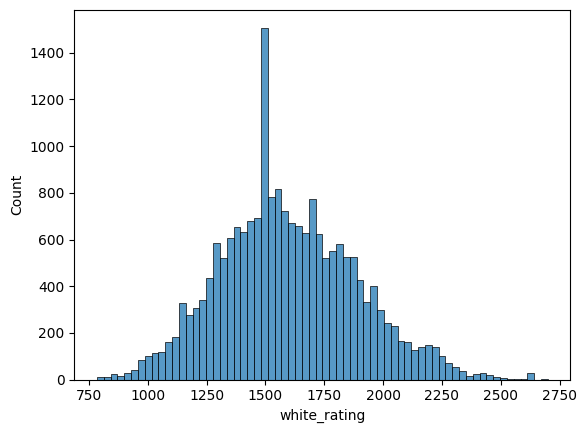

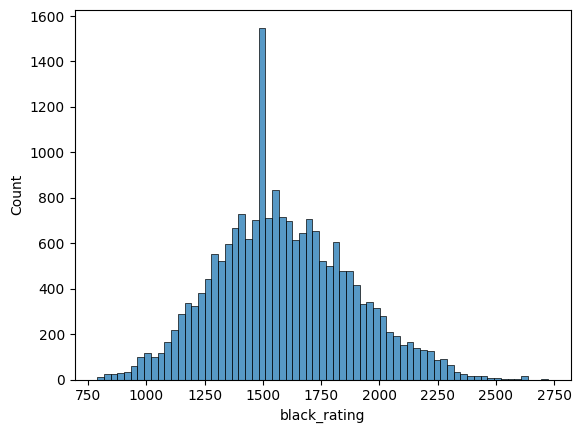

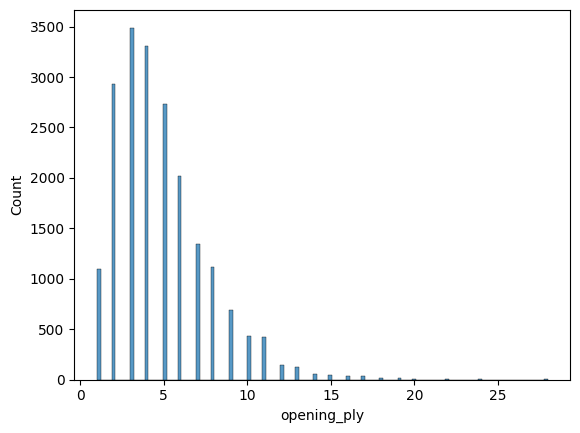

In [64]:
chess_numerical = df.select_dtypes(include=np.number)
chess_categorical = df.select_dtypes(include='object')

for i in chess_numerical:
  sns.histplot(chess_numerical, x=i)
  plt.show()

In [65]:
for i in chess_numerical:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of created_at: -1.78
Skewness of last_move_at: -1.78
Skewness of turns: 0.90
Skewness of white_rating: 0.30
Skewness of black_rating: 0.26
Skewness of opening_ply: 1.33


# feature Enginering

In [69]:
df['duration'] = df['last_move_at'] - df['created_at']
q99 = df['duration'].quantile(0.99)
df['duration_cap'] = np.where(df['duration']> q99, q99, df['duration'])
df['duration_log'] = np.log1p(df['duration_cap'])
df['duration'] = df['duration_log']
df.drop(columns=['duration_cap', 'duration_log','created_at', 'last_move_at'], inplace=True)
chess_numerical = df.select_dtypes(include=np.number)

for i in chess_numerical:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of turns: 0.90
Skewness of white_rating: 0.30
Skewness of black_rating: 0.26
Skewness of opening_ply: 1.33
Skewness of duration: -0.24


In [72]:
df['opening_ply'] = np.log1p(df['opening_ply'])
df['opening_ply'].skew()
chess_numerical = df.select_dtypes(include=np.number)

for i in chess_numerical:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of turns: 0.90
Skewness of white_rating: 0.30
Skewness of black_rating: 0.26
Skewness of opening_ply: -0.72
Skewness of duration: -0.24
